# FuelProphet model

In [11]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score 
import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_laura.nico_fuelprophet_abs import FuelProphet_abs


# MLFlow setup

In [12]:
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"FuelProphet_Nico_Loop_{timestamp}"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Adjusted print model function

In [13]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['datetime'] >= train_dates[0]) & (df_train['datetime'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['datetime'] >= test_dates[0]) & (df_test['datetime'] <= test_dates[1]) if test_dates else slice(None)

    

    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['datetime'] >= train_dates[0]) & (df_train_prediction['datetime'] <= train_dates[1])]
        #plt.plot(df_train_prediction['datetime'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['datetime'] >= test_dates[0]) & (df_test_prediction['datetime'] <= test_dates[1])]
        plt.plot(df_test_prediction['datetime'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='datetime', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('datetime').reset_index(drop=True)

        mae_dict = {}
        rmse_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['datetime'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['datetime'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                rmse = np.sqrt(mean_squared_error(df_subset['e5_actual'], df_subset['e5_pred']))
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                rmse_dict[days] = rmse
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day RMSE in cent: {rmse *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                #plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         #transform=plt.gca().transAxes, fontsize=12, 
                         #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))

    plt.plot(df_train.loc[train_mask, 'datetime'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'datetime'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.show()
    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)
    rmse_1_day = rmse_dict.get(1)
    rmse_3_day = rmse_dict.get(3)
    rmse_7_day = rmse_dict.get(7)
    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)
    
    return mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day
    


# Load Datasets

In [14]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

In [15]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

In [16]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}

# Fit Model


Processing dataset: df01
[0.0059886  0.46493404 0.03293166 0.0551843  0.44096139]
[  -1  -36 -288 -576 -864]
1-Day MAE in cent: 8.2885
1-Day RMSE in cent: 8.7965
1-Day r2-score: -13.5845
3-Day MAE in cent: 7.4990
3-Day RMSE in cent: 7.9006
3-Day r2-score: -11.3327
7-Day MAE in cent: 7.0052
7-Day RMSE in cent: 7.4567
7-Day r2-score: -7.7777


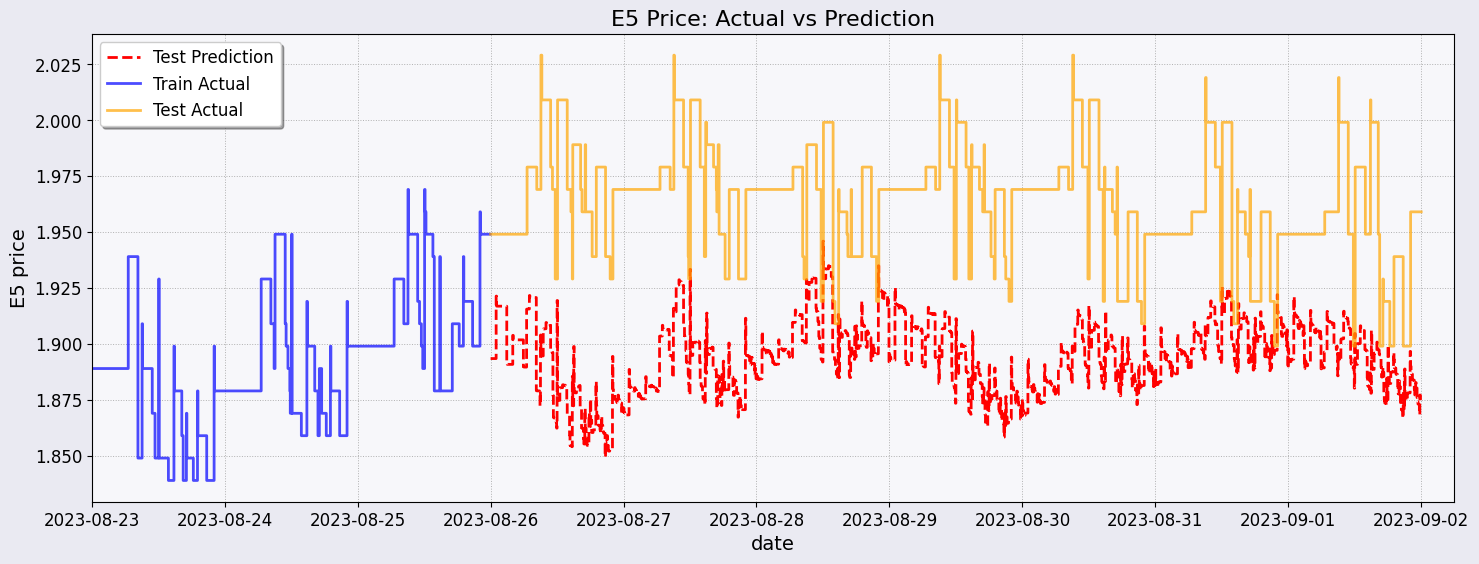

Successfully processed df01

Processing dataset: df02
[0.10993832 0.89006168]
[  -1 -288]
1-Day MAE in cent: 2.6765
1-Day RMSE in cent: 3.3866
1-Day r2-score: -0.3359
3-Day MAE in cent: 2.3906
3-Day RMSE in cent: 3.2288
3-Day r2-score: -0.1176
7-Day MAE in cent: 2.0007
7-Day RMSE in cent: 2.8062
7-Day r2-score: 0.2626


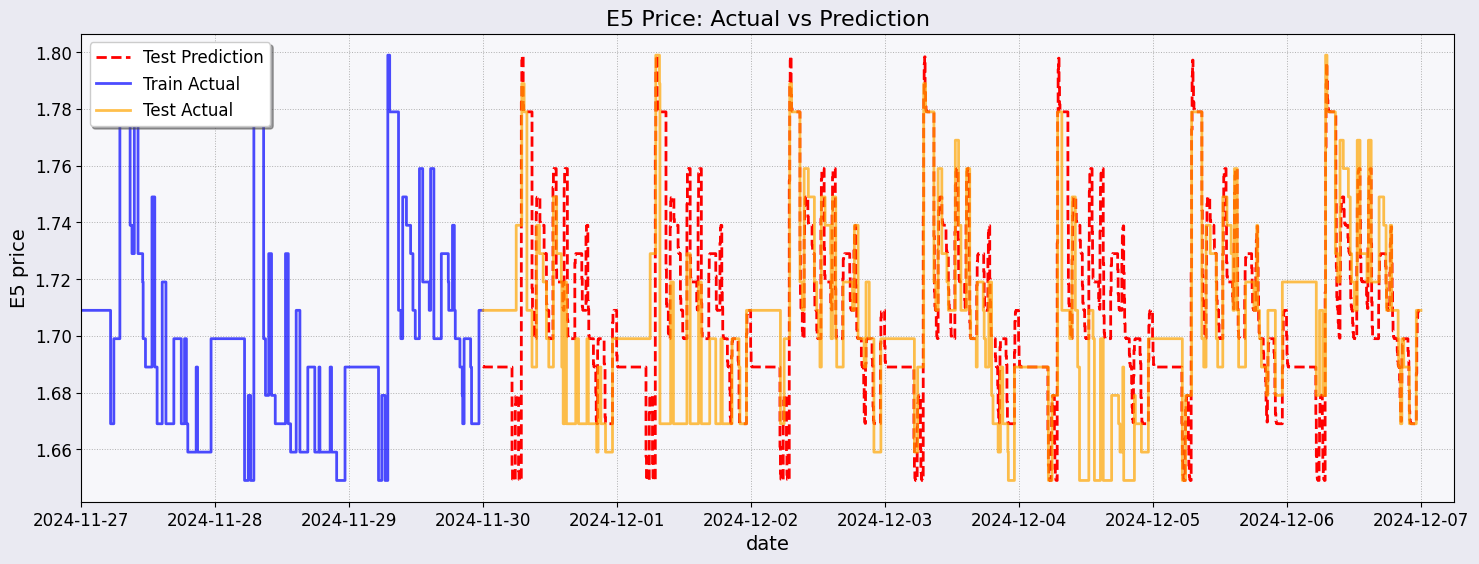

Successfully processed df02

Processing dataset: df03
[0.01819718 0.00926218 0.05824741 0.19049641 0.72379682]
[  -1 -168 -288 -576 -864]
1-Day MAE in cent: 1.4856
1-Day RMSE in cent: 2.0439
1-Day r2-score: 0.5336
3-Day MAE in cent: 1.6773
3-Day RMSE in cent: 2.4004
3-Day r2-score: 0.4457
7-Day MAE in cent: 2.3579
7-Day RMSE in cent: 3.1383
7-Day r2-score: 0.3211


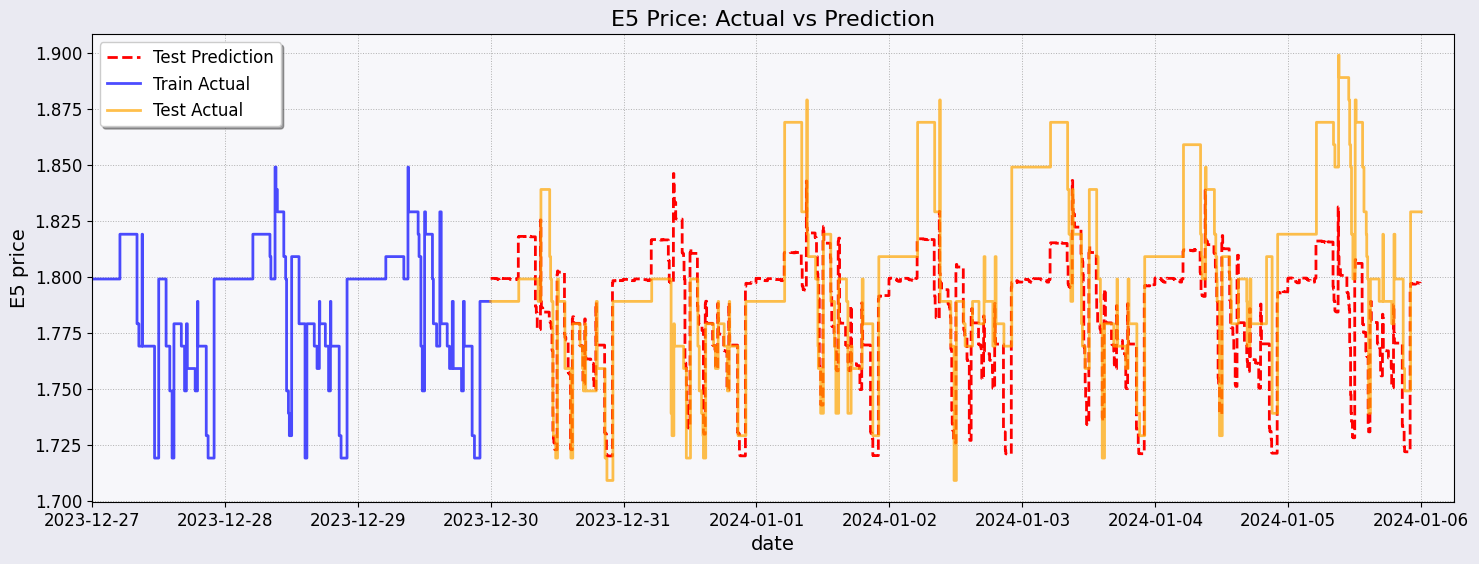

Successfully processed df03

Processing dataset: df04
[0.26125106 0.73874894]
[  -1 -288]
1-Day MAE in cent: 2.0273
1-Day RMSE in cent: 2.7793
1-Day r2-score: -0.2105
3-Day MAE in cent: 1.4577
3-Day RMSE in cent: 2.2418
3-Day r2-score: 0.3686
7-Day MAE in cent: 1.6101
7-Day RMSE in cent: 2.5113
7-Day r2-score: 0.3461


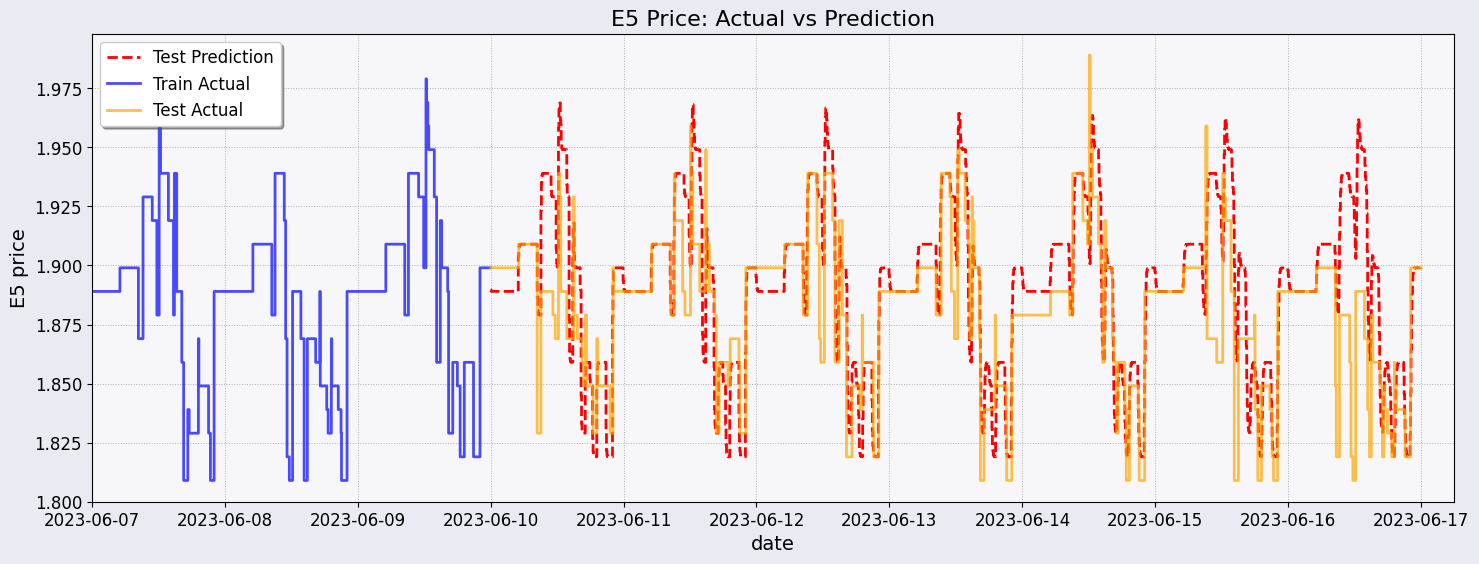

Successfully processed df04

Processing dataset: df05
[0.04383016 0.95616984]
[  -1 -288]
1-Day MAE in cent: 2.5014
1-Day RMSE in cent: 3.4687
1-Day r2-score: -0.6380
3-Day MAE in cent: 4.0091
3-Day RMSE in cent: 5.2814
3-Day r2-score: -0.2609
7-Day MAE in cent: 3.6270
7-Day RMSE in cent: 4.8271
7-Day r2-score: -0.4548


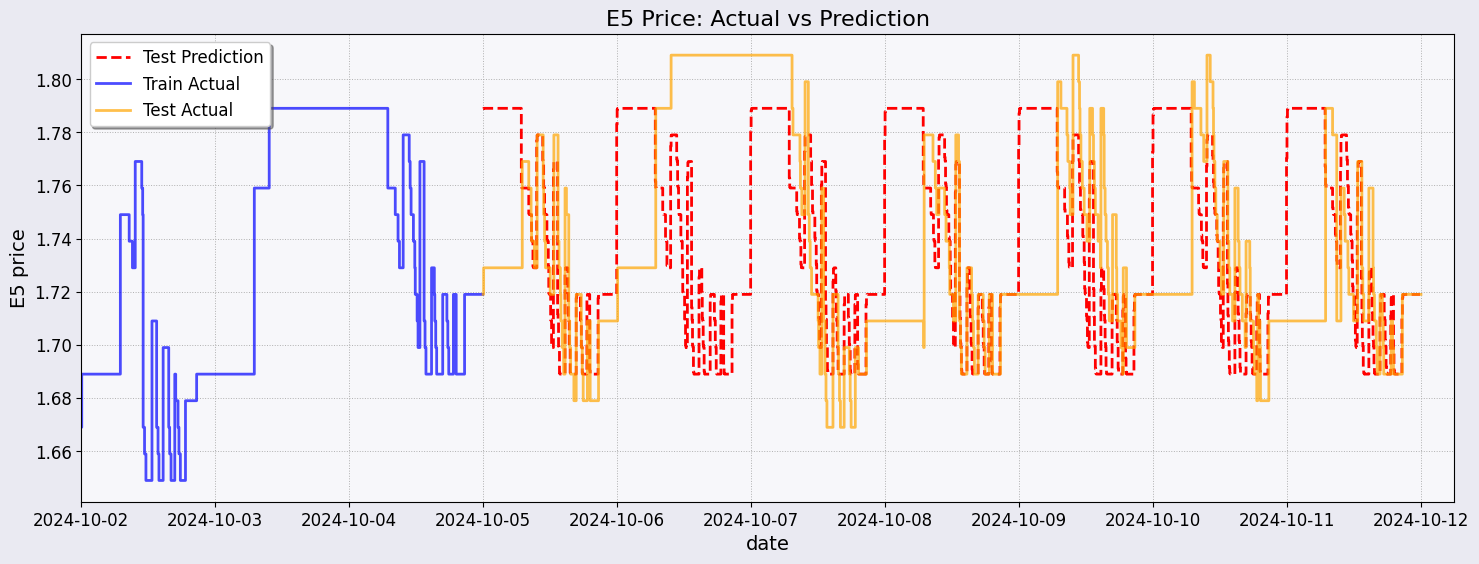

Successfully processed df05

Processing dataset: df06
[0.05623614 0.1023095  0.04479028 0.10577635 0.09749404 0.59339369]
[  -1  -24  -48 -288 -576 -864]
1-Day MAE in cent: 1.2098
1-Day RMSE in cent: 1.7654
1-Day r2-score: 0.8229
3-Day MAE in cent: 1.7067
3-Day RMSE in cent: 2.6978
3-Day r2-score: 0.5628
7-Day MAE in cent: 1.7067
7-Day RMSE in cent: 2.6978
7-Day r2-score: 0.5628


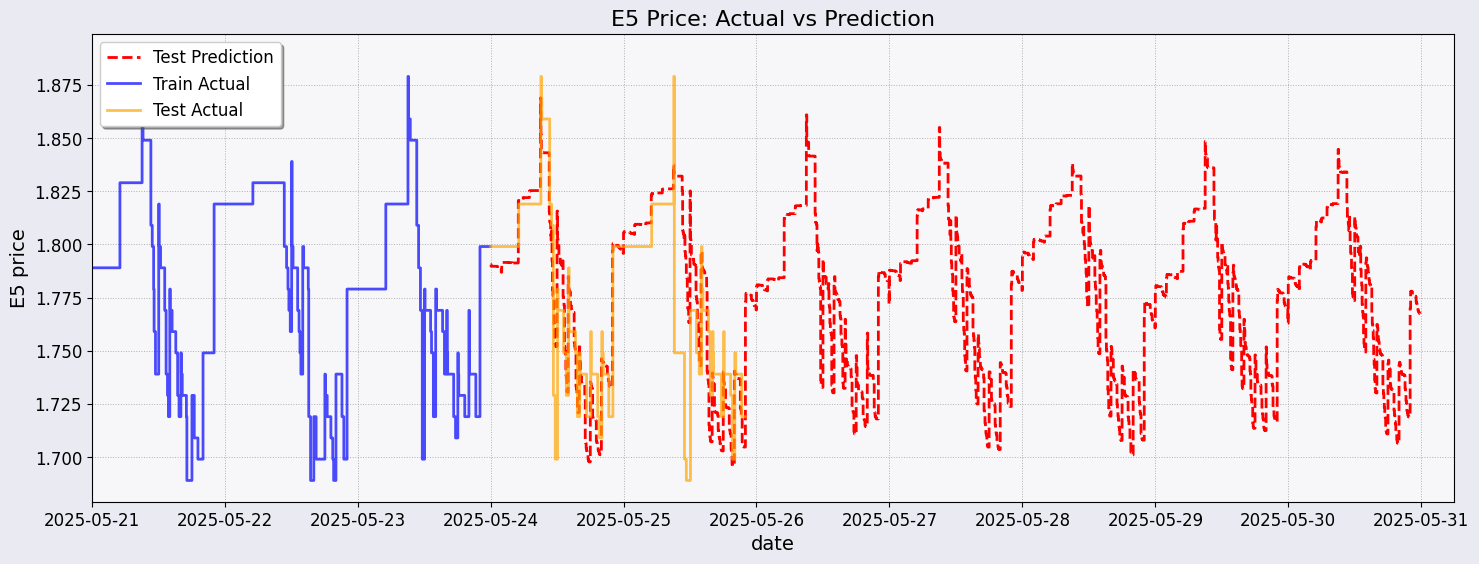

Successfully processed df06

Processing dataset: df07
[0.25822487 0.46770001 0.27407512]
[  -1 -288 -289]
1-Day MAE in cent: 0.9217
1-Day RMSE in cent: 1.5989
1-Day r2-score: 0.6742
3-Day MAE in cent: 1.1576
3-Day RMSE in cent: 1.9752
3-Day r2-score: 0.6128
7-Day MAE in cent: 1.3497
7-Day RMSE in cent: 2.0391
7-Day r2-score: 0.5368


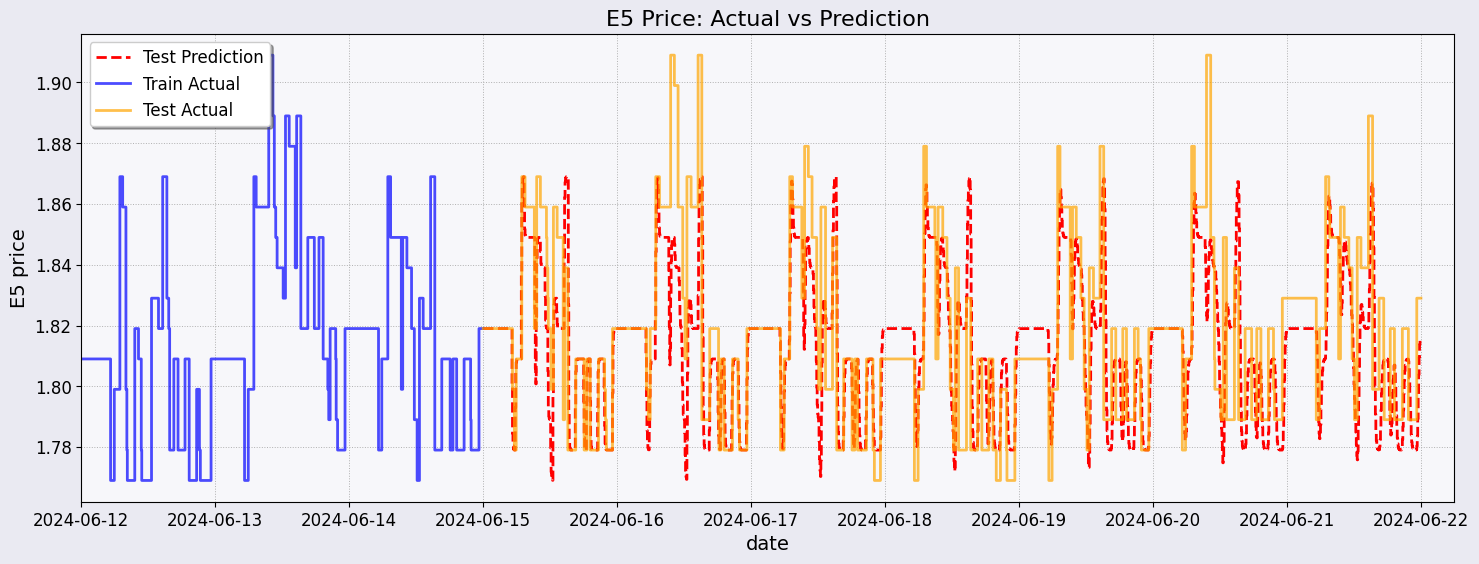

Successfully processed df07

Processing dataset: df08
[1.]
[-1]
1-Day MAE in cent: 1.6528
1-Day RMSE in cent: 3.4177
1-Day r2-score: -0.3053
3-Day MAE in cent: 2.1620
3-Day RMSE in cent: 3.7389
3-Day r2-score: -0.5024
7-Day MAE in cent: 2.5777
7-Day RMSE in cent: 4.4105
7-Day r2-score: -0.4551


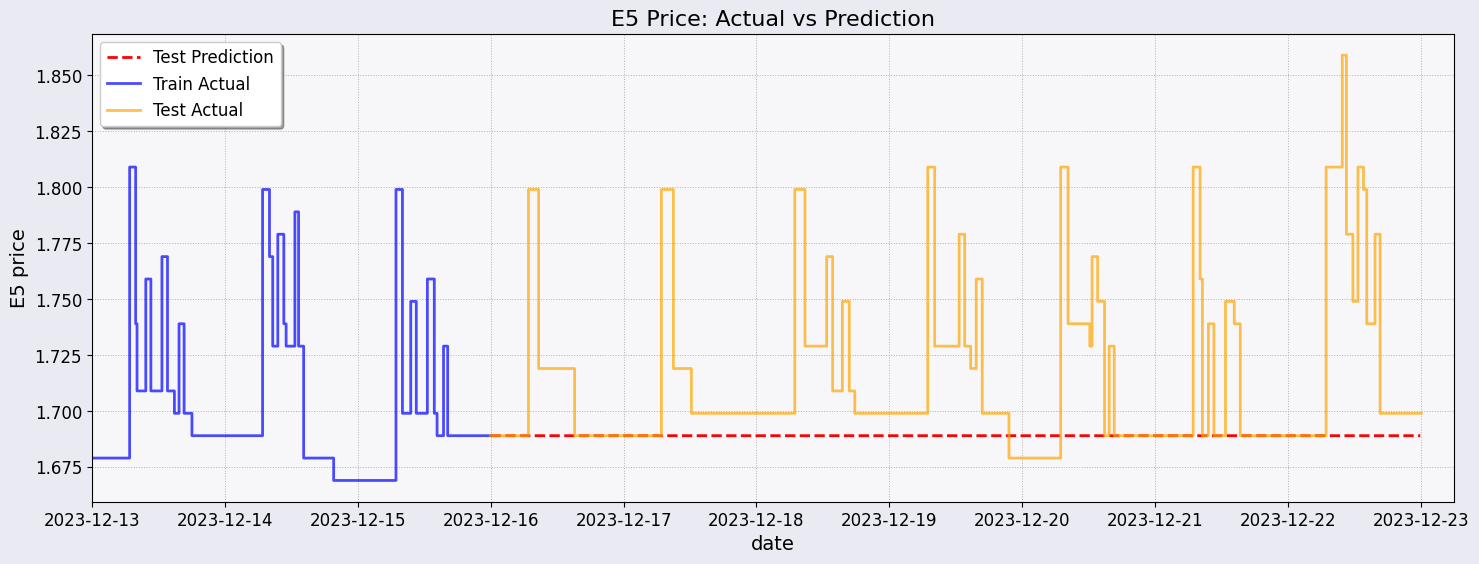

Successfully processed df08

Processing dataset: df09
[0.03466157 0.0173221  0.06513103 0.05851803 0.00073639 0.18115536
 0.64247553]
[  -1   -9  -15  -24 -288 -576 -864]
1-Day MAE in cent: 1.0457
1-Day RMSE in cent: 1.4713
1-Day r2-score: 0.7326
3-Day MAE in cent: 0.8542
3-Day RMSE in cent: 1.4011
3-Day r2-score: 0.7699
7-Day MAE in cent: 1.6937
7-Day RMSE in cent: 2.5092
7-Day r2-score: 0.2260


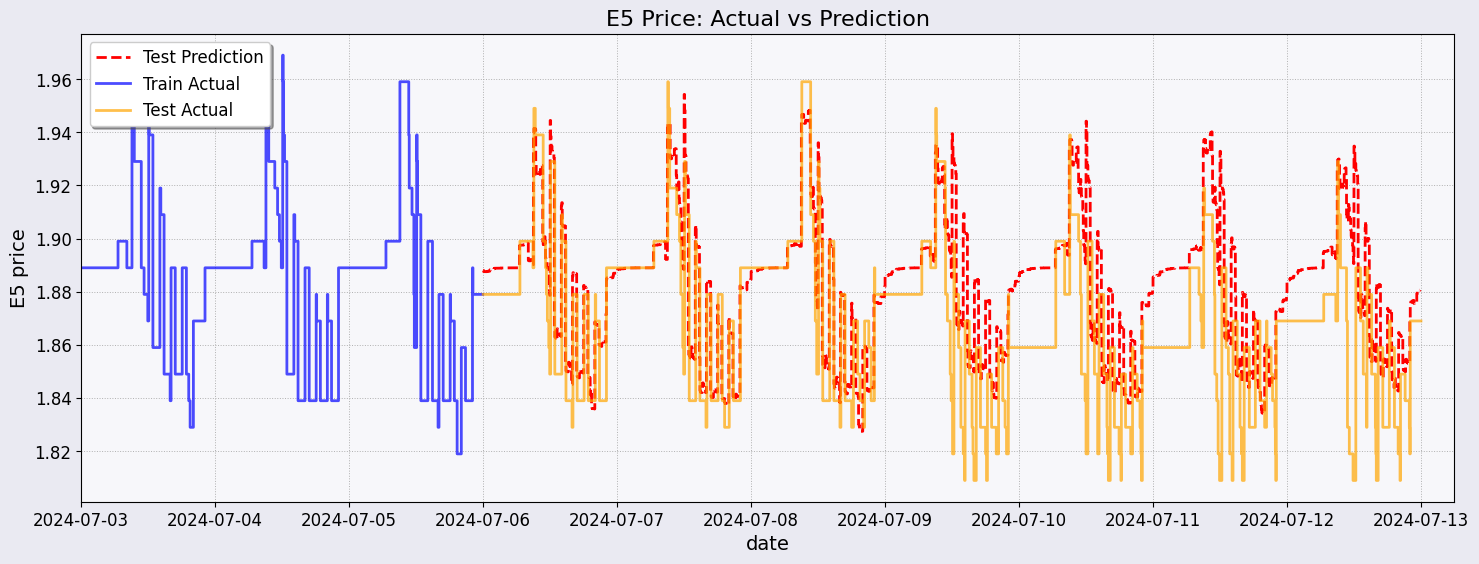

Successfully processed df09

Processing dataset: df10
[0.71805289 0.28194711]
[  -1 -288]
1-Day MAE in cent: 1.6768
1-Day RMSE in cent: 2.3146
1-Day r2-score: 0.2992
3-Day MAE in cent: 1.7571
3-Day RMSE in cent: 2.3113
3-Day r2-score: 0.0620
7-Day MAE in cent: 2.0308
7-Day RMSE in cent: 2.5532
7-Day r2-score: -0.0119


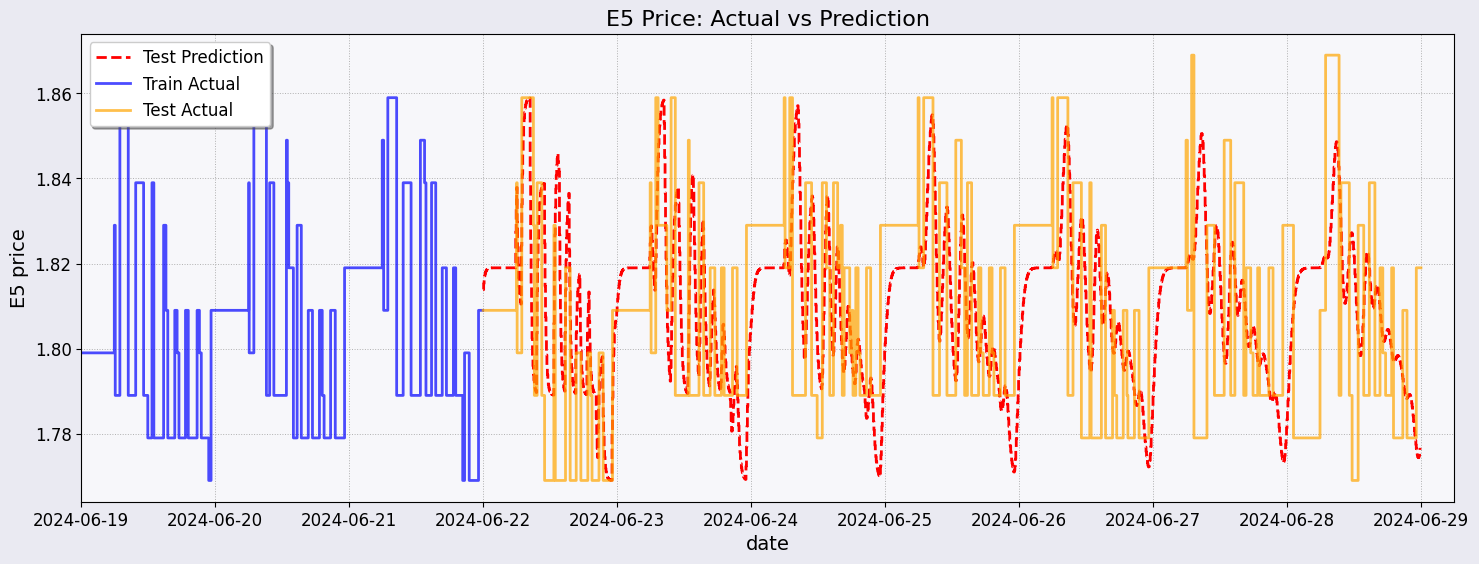

Successfully processed df10

Processing dataset: df11
[0.66724355 0.33275645]
[  -1 -288]
1-Day MAE in cent: 2.1256
1-Day RMSE in cent: 2.9835
1-Day r2-score: 0.3849
3-Day MAE in cent: 2.4516
3-Day RMSE in cent: 3.3308
3-Day r2-score: 0.0643
7-Day MAE in cent: 2.8911
7-Day RMSE in cent: 3.7453
7-Day r2-score: 0.3631


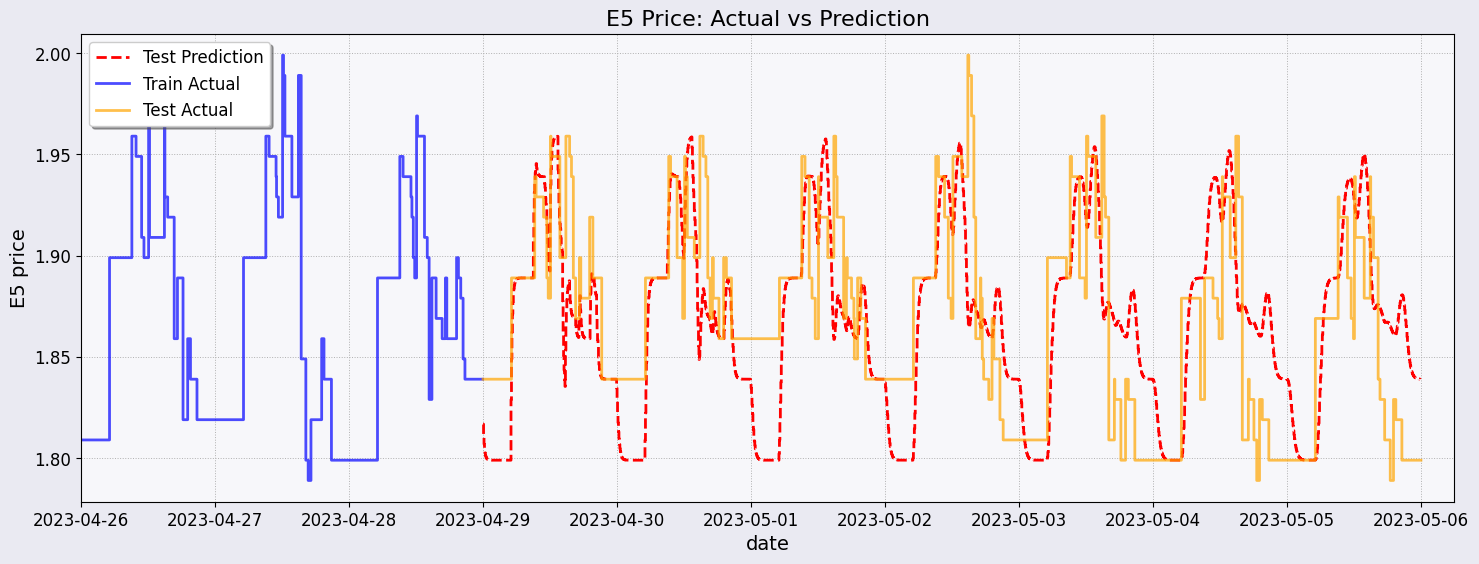

Successfully processed df11

Processing dataset: df12
[0.02047743 0.05425672 0.03918176 0.10863501 0.77744907]
[  -1 -286 -288 -576 -864]
1-Day MAE in cent: 2.1160
1-Day RMSE in cent: 2.5692
1-Day r2-score: 0.5262
3-Day MAE in cent: 1.9450
3-Day RMSE in cent: 2.3947
3-Day r2-score: 0.5595
7-Day MAE in cent: 1.9708
7-Day RMSE in cent: 2.3648
7-Day r2-score: 0.4577


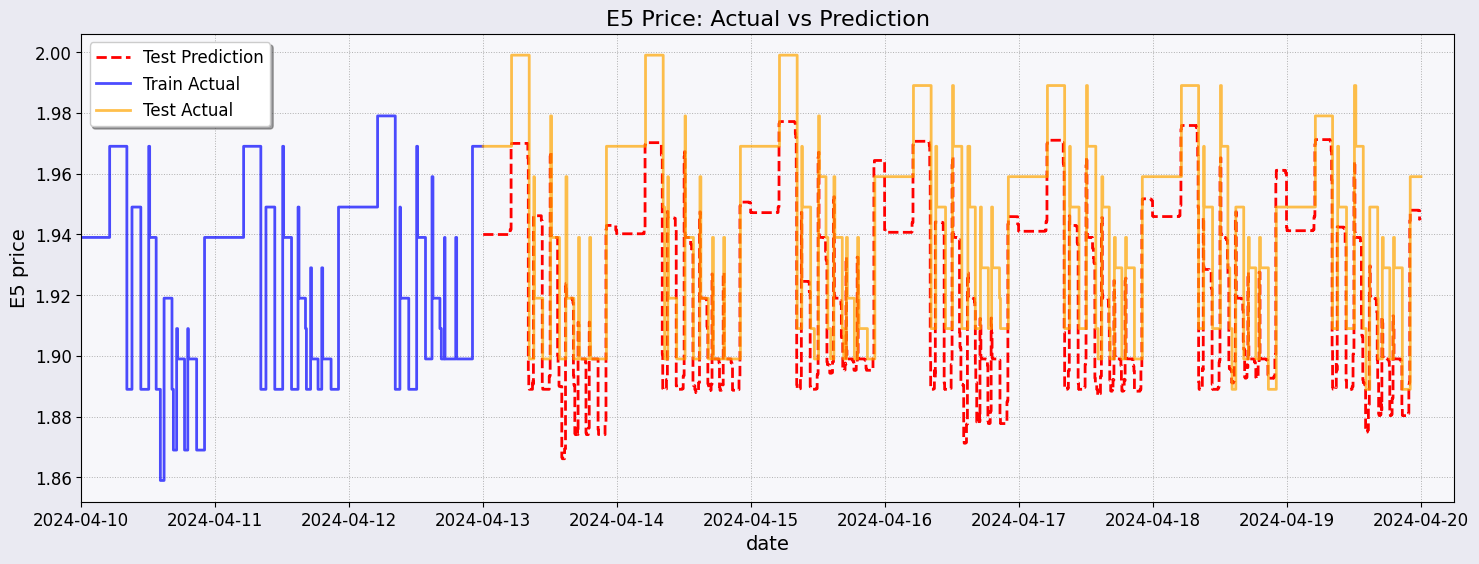

Successfully processed df12

Processing dataset: df13
[0.0046528 0.9953472]
[  -1 -288]
1-Day MAE in cent: 2.2323
1-Day RMSE in cent: 3.2895
1-Day r2-score: -0.1273
3-Day MAE in cent: 1.6730
3-Day RMSE in cent: 2.5552
3-Day r2-score: 0.3075
7-Day MAE in cent: 1.5935
7-Day RMSE in cent: 2.3658
7-Day r2-score: 0.5043


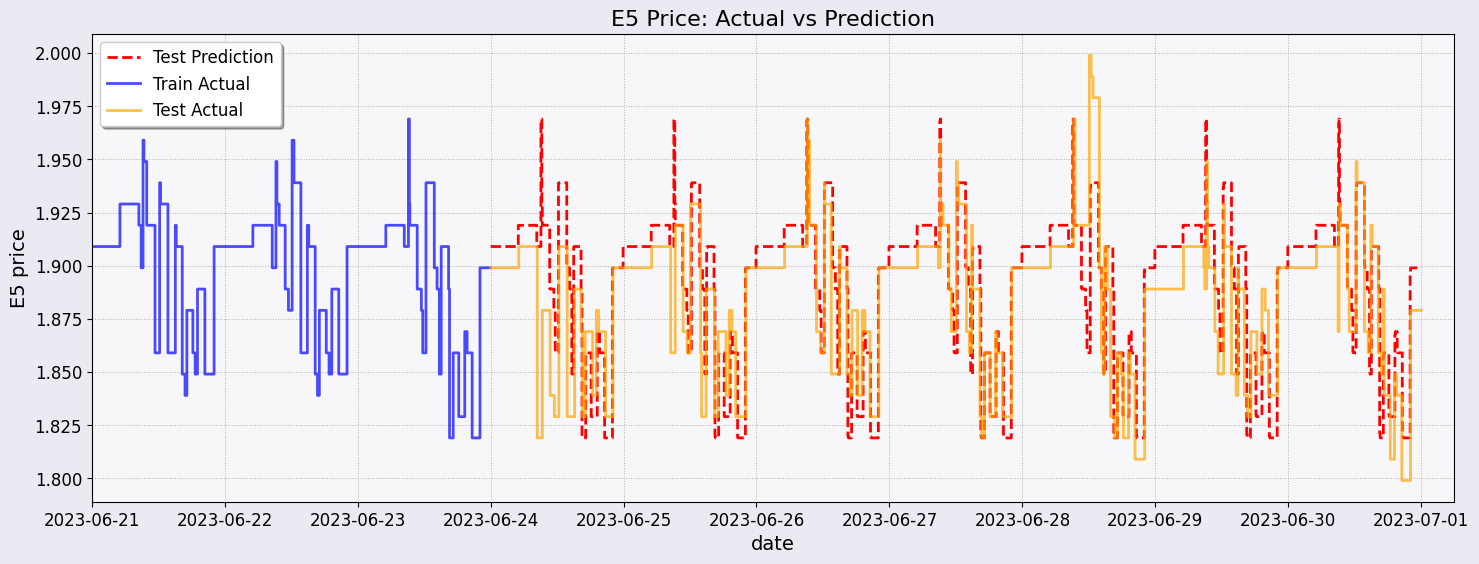

Successfully processed df13

Processing dataset: df14
[0.13360353 0.01515918 0.02657525 0.05993362 0.76472842]
[  -1  -84 -288 -576 -864]
1-Day MAE in cent: 2.6937
1-Day RMSE in cent: 3.0238
1-Day r2-score: 0.1721
3-Day MAE in cent: 2.9606
3-Day RMSE in cent: 3.5709
3-Day r2-score: -0.1707
7-Day MAE in cent: 3.5890
7-Day RMSE in cent: 4.0854
7-Day r2-score: -0.2568


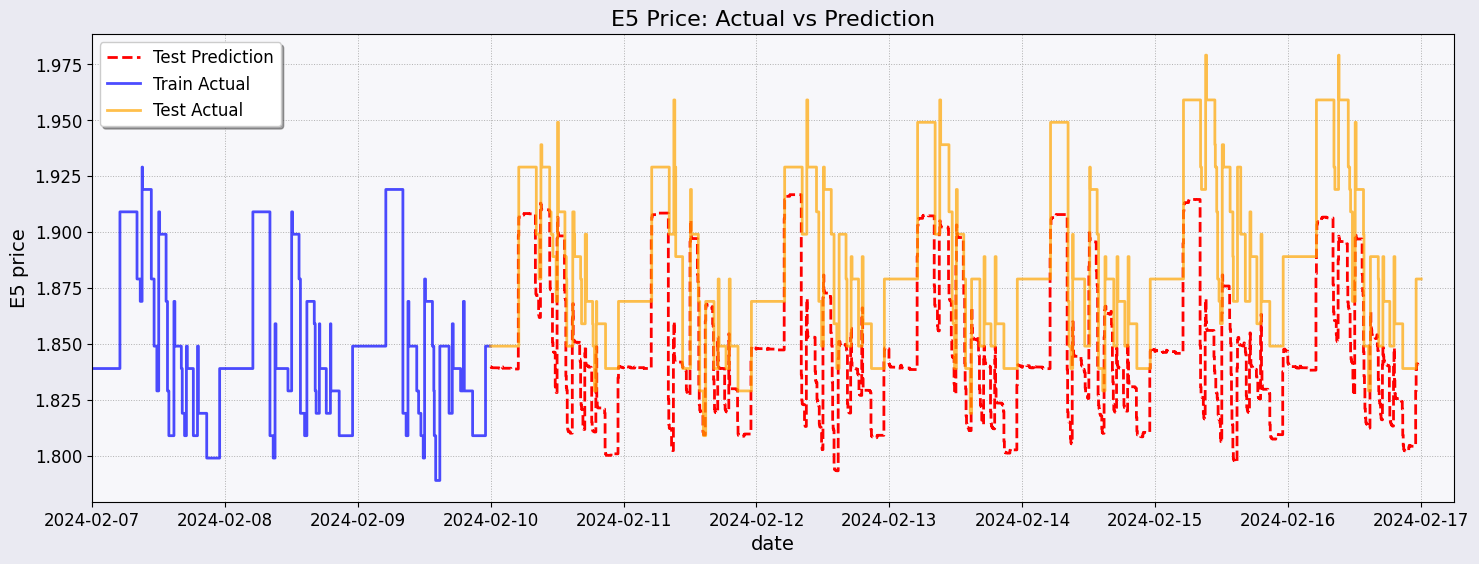

Successfully processed df14

Processing dataset: df15
[0.33757478 0.270048   0.07124548 0.32113173]
[  -1 -288 -289 -576]
1-Day MAE in cent: 2.0134
1-Day RMSE in cent: 2.4965
1-Day r2-score: 0.5244
3-Day MAE in cent: 2.4145
3-Day RMSE in cent: 3.1174
3-Day r2-score: 0.5100
7-Day MAE in cent: 2.0199
7-Day RMSE in cent: 2.5959
7-Day r2-score: 0.6147


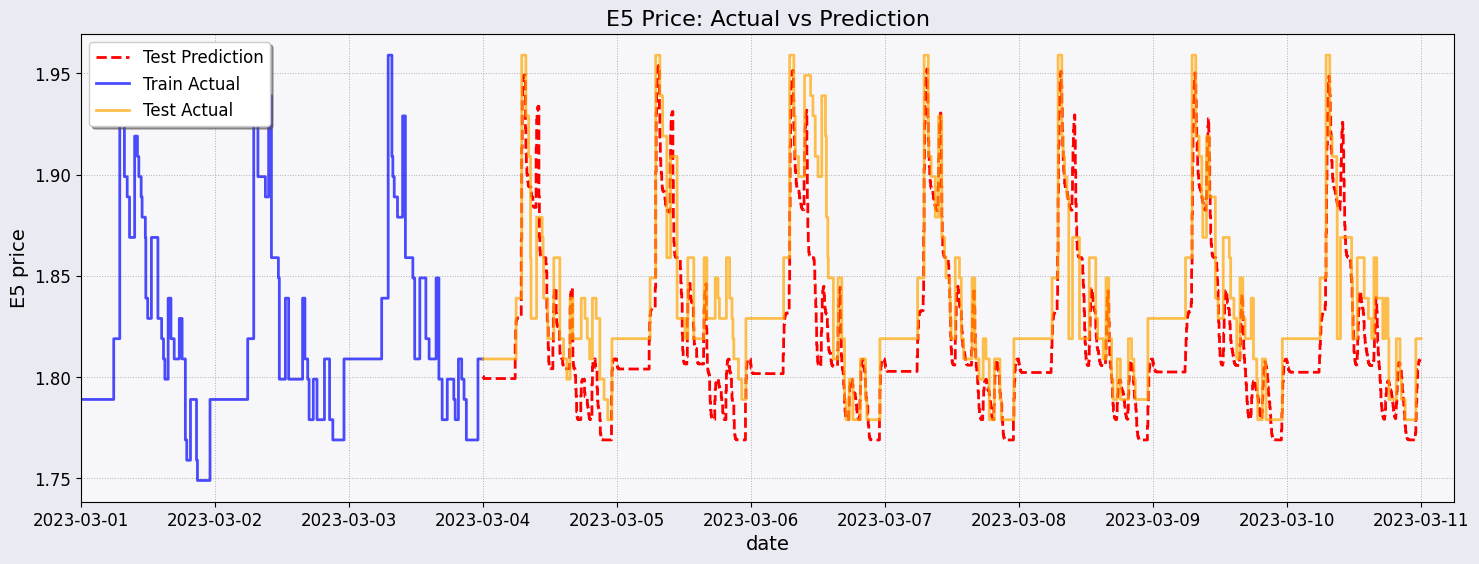

Successfully processed df15

Processing dataset: df16
[0.05766022 0.15955307 0.09585939 0.68692732]
[  -1  -24 -288 -576]
1-Day MAE in cent: 2.4276
1-Day RMSE in cent: 2.9547
1-Day r2-score: 0.0867
3-Day MAE in cent: 2.1191
3-Day RMSE in cent: 2.6114
3-Day r2-score: 0.3440
7-Day MAE in cent: 1.9651
7-Day RMSE in cent: 2.5307
7-Day r2-score: 0.3931


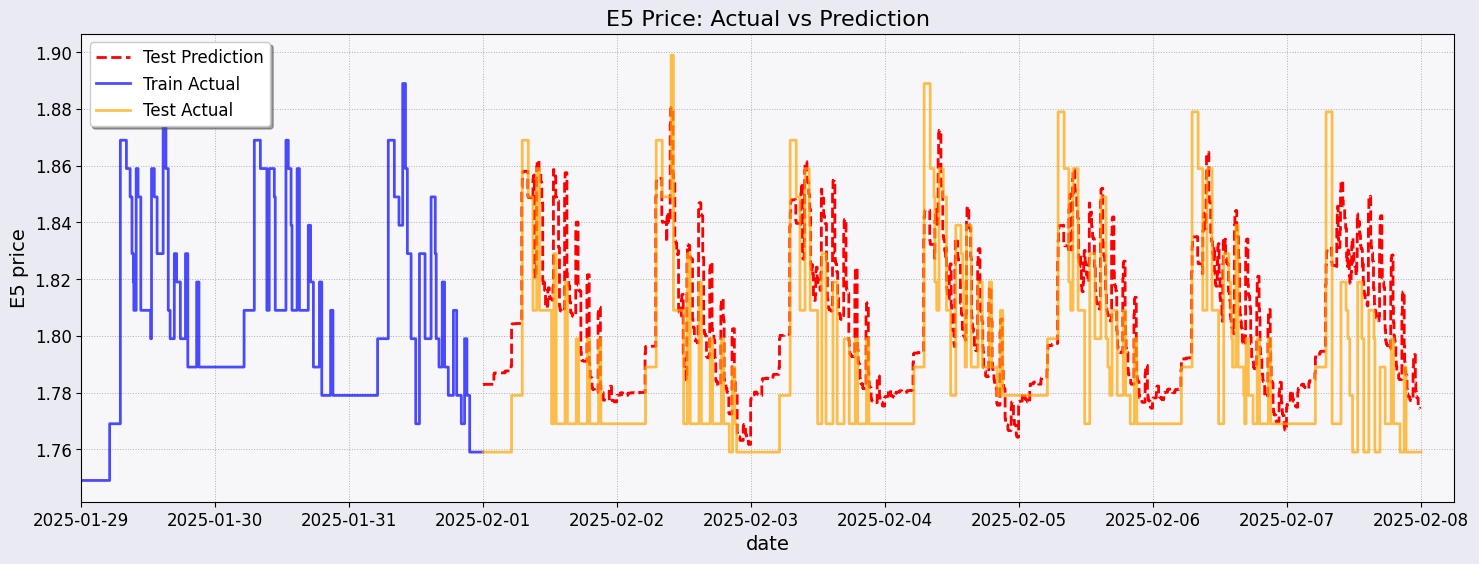

Successfully processed df16

Processing dataset: df17
[0.01461178 0.06045728 0.17005863 0.12638893 0.62848338]
[  -1  -84 -288 -576 -864]
1-Day MAE in cent: 1.2990
1-Day RMSE in cent: 1.7427
1-Day r2-score: 0.8466
3-Day MAE in cent: 1.7285
3-Day RMSE in cent: 2.4507
3-Day r2-score: 0.6940
7-Day MAE in cent: 1.6202
7-Day RMSE in cent: 2.2449
7-Day r2-score: 0.7495


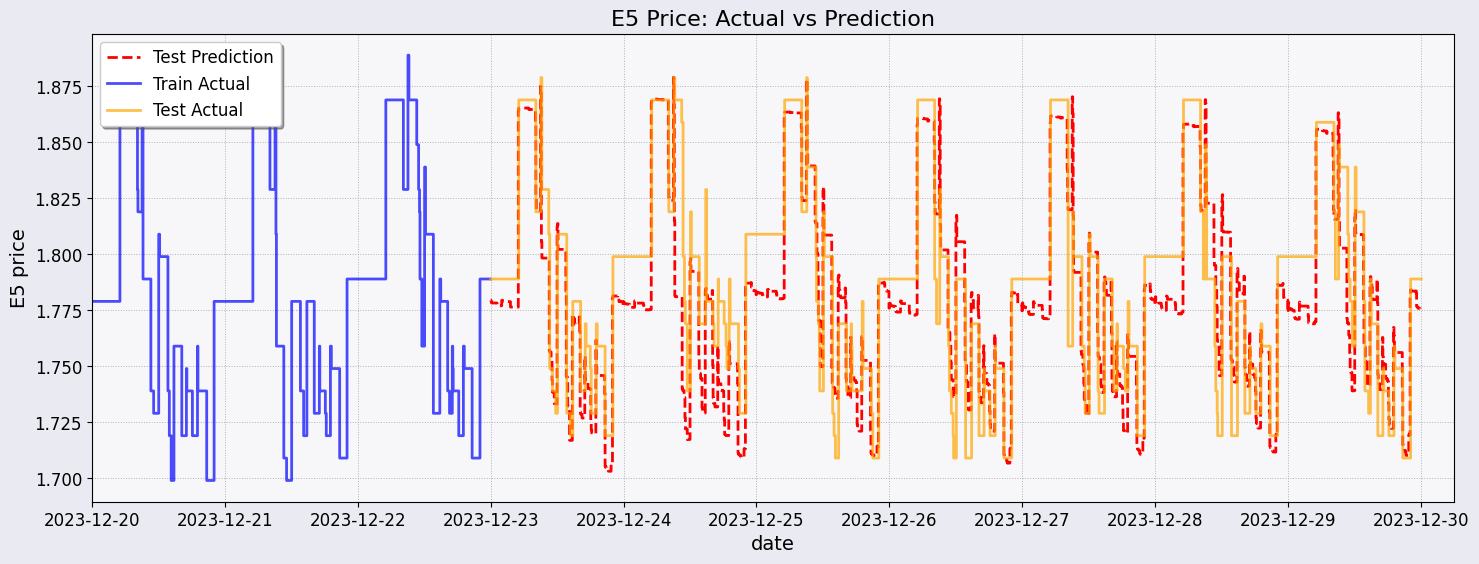

Successfully processed df17

Processing dataset: df18
[0.0406065  0.47012322 0.48927028]
[  -1 -288 -576]
1-Day MAE in cent: 1.3766
1-Day RMSE in cent: 1.8160
1-Day r2-score: 0.6801
3-Day MAE in cent: 1.6915
3-Day RMSE in cent: 2.1939
3-Day r2-score: 0.5693
7-Day MAE in cent: 1.8904
7-Day RMSE in cent: 2.5202
7-Day r2-score: 0.5241


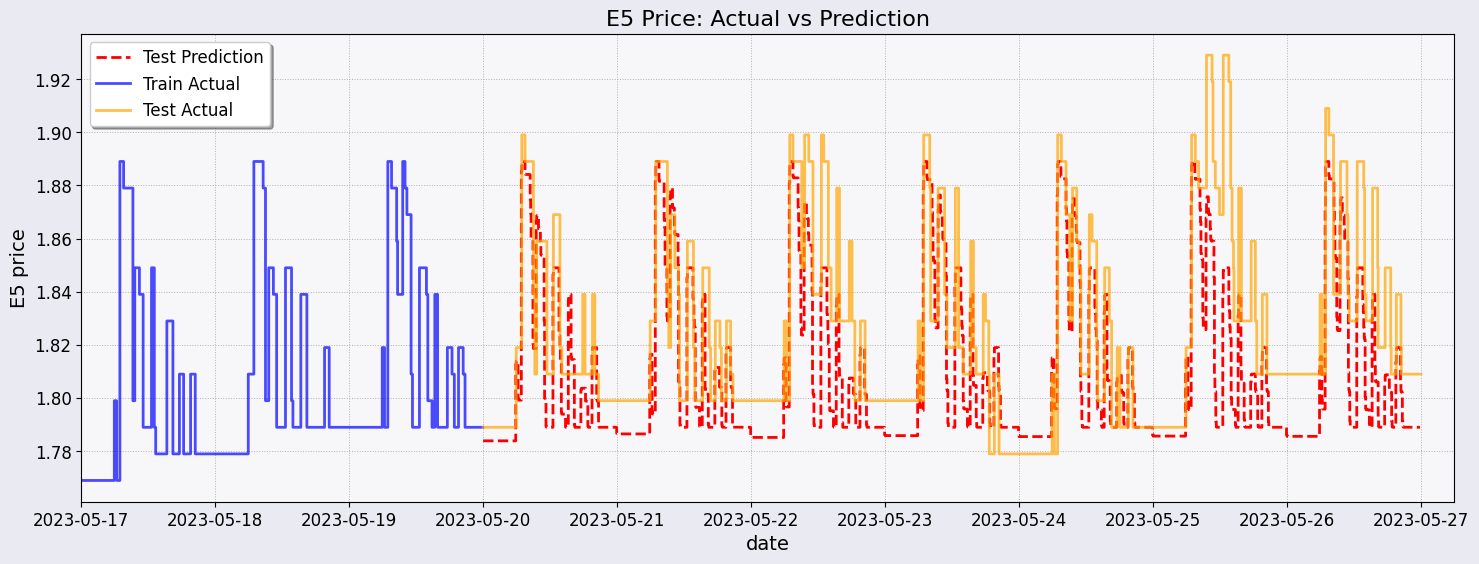

Successfully processed df18

Processing dataset: df19
[1.]
[-1]
1-Day MAE in cent: 0.6910
1-Day RMSE in cent: 0.8312
1-Day r2-score: -2.2360
3-Day MAE in cent: 0.8970
3-Day RMSE in cent: 0.9471
3-Day r2-score: -8.7079
7-Day MAE in cent: 0.6700
7-Day RMSE in cent: 0.8185
7-Day r2-score: -0.2824


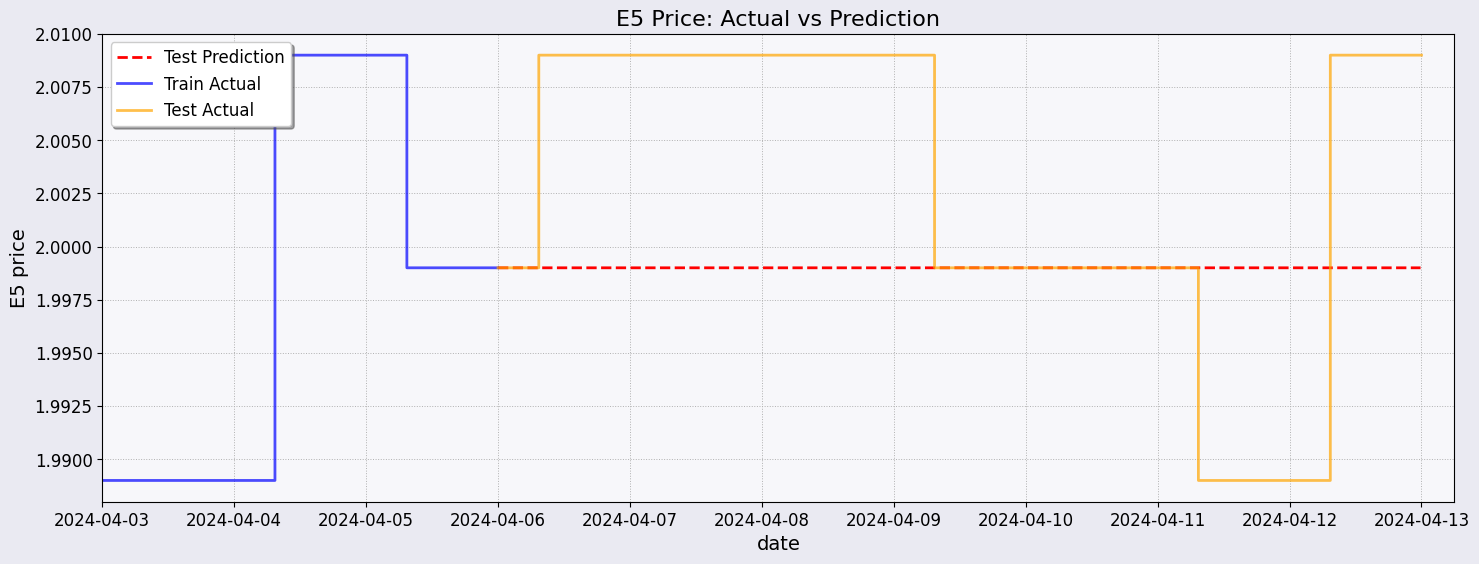

Successfully processed df19

Processing dataset: df20


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1489: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


[0.25801387 0.25801387 0.2447798  0.23919247]
[-1 -1 -2 -3]
1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 1.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 1.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 1.0000


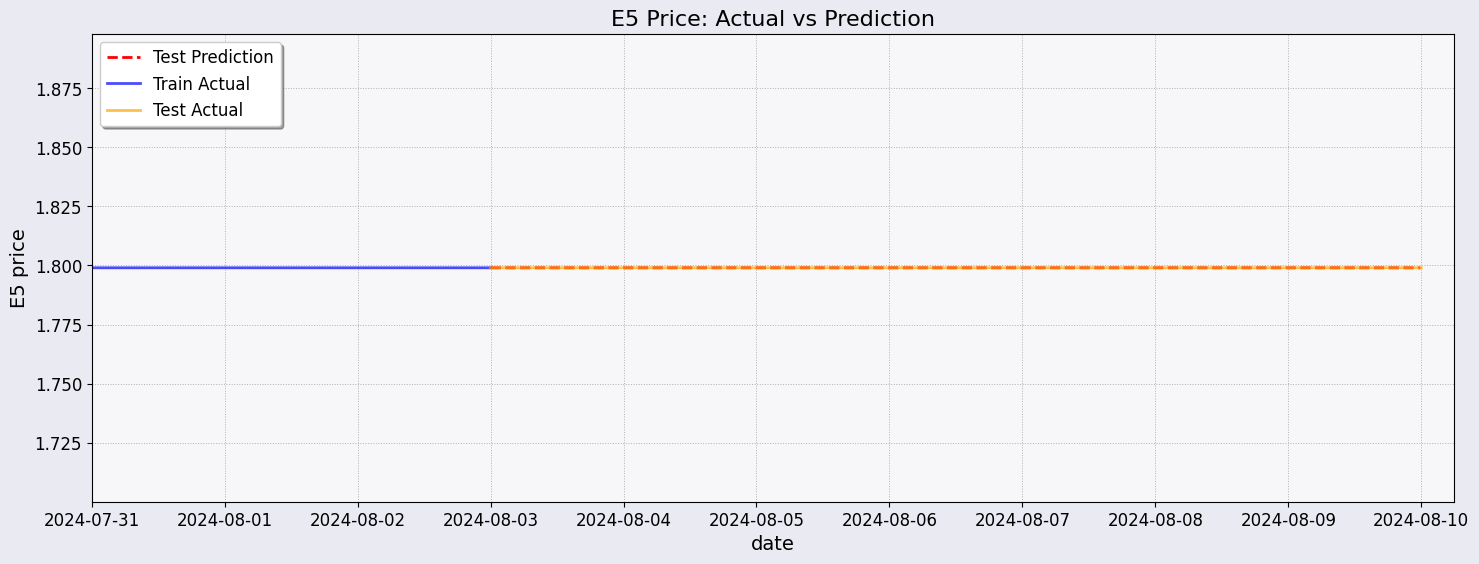

Successfully processed df20

Processing dataset: df21
[0.01166776 0.01813274 0.0770285  0.09957758 0.79359343]
[  -1  -33 -288 -576 -864]
1-Day MAE in cent: 1.1751
1-Day RMSE in cent: 1.6031
1-Day r2-score: 0.4265
3-Day MAE in cent: 1.2952
3-Day RMSE in cent: 1.7056
3-Day r2-score: 0.2469
7-Day MAE in cent: 1.3332
7-Day RMSE in cent: 1.7167
7-Day r2-score: 0.2766


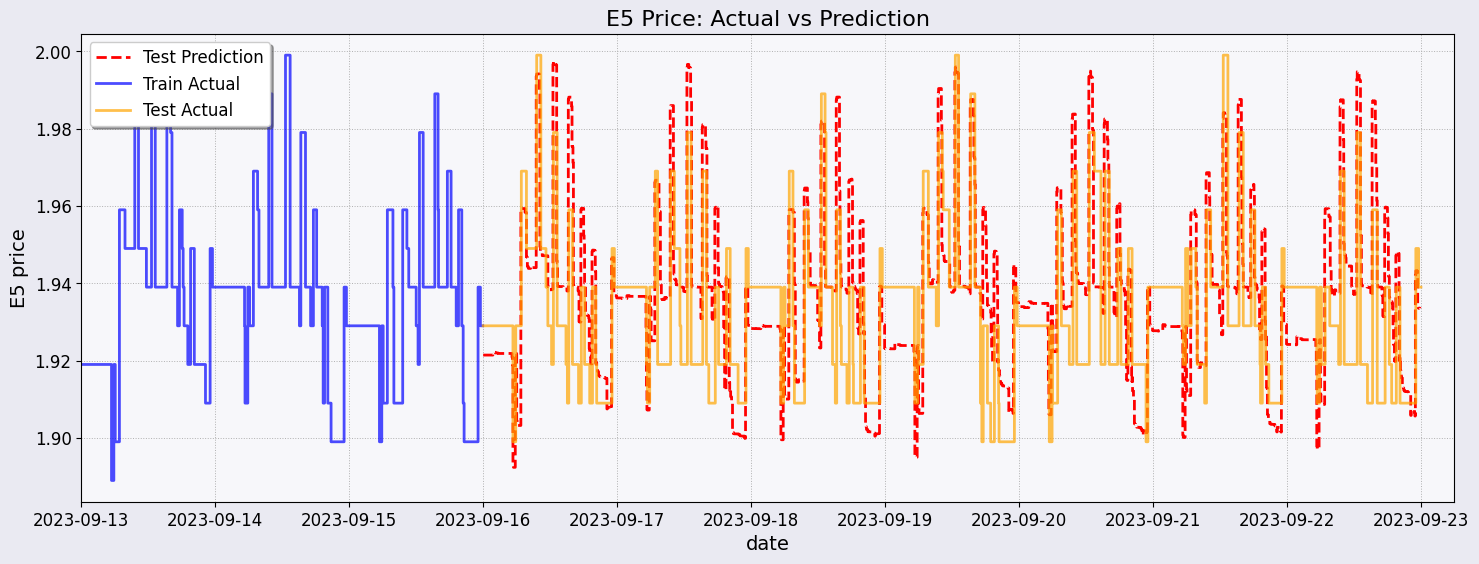

Successfully processed df21

Processing dataset: df22
[0.07753353 0.68537145 0.03745146 0.02966102 0.16998254]
[  -1  -36 -252 -288 -576]
1-Day MAE in cent: 1.9755
1-Day RMSE in cent: 2.5756
1-Day r2-score: -0.0506
3-Day MAE in cent: 2.4971
3-Day RMSE in cent: 3.1041
3-Day r2-score: -0.2675
7-Day MAE in cent: 2.7933
7-Day RMSE in cent: 3.4838
7-Day r2-score: -0.3403


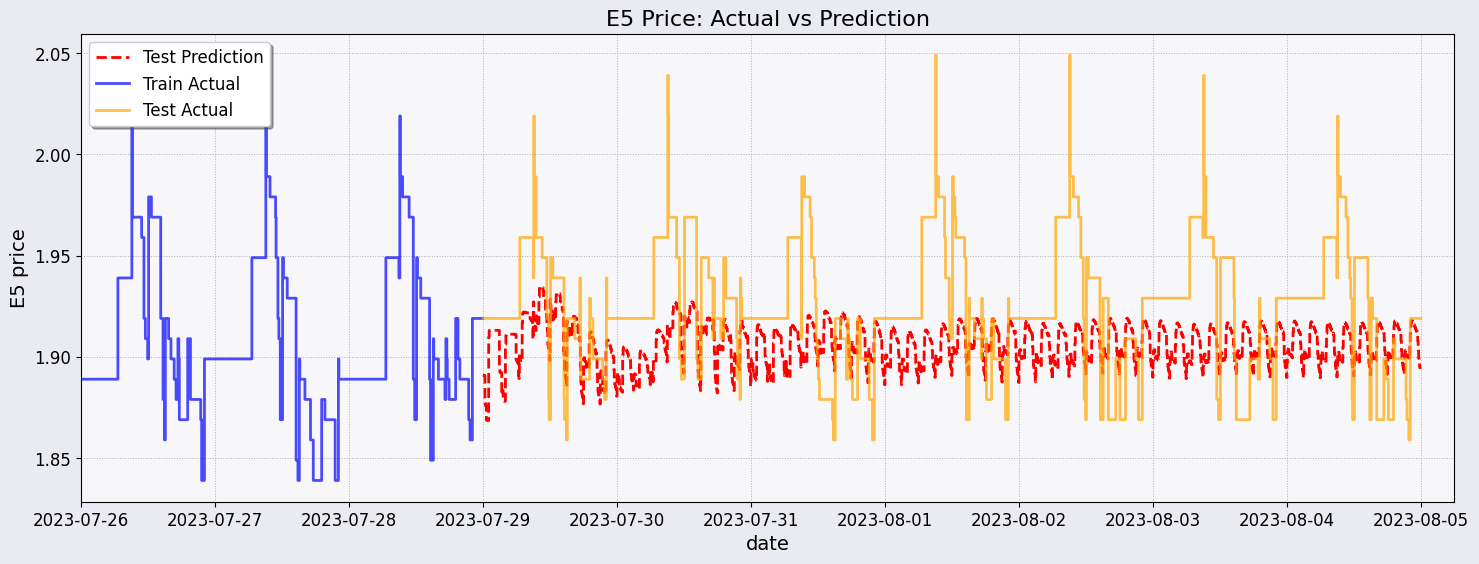

Successfully processed df22

Processing dataset: df23
[3.12529617e-04 1.11675575e-01 7.69591875e-02 8.11052708e-01]
[  -1 -288 -576 -864]
1-Day MAE in cent: 1.6806
1-Day RMSE in cent: 2.4323
1-Day r2-score: 0.3521
3-Day MAE in cent: 1.5105
3-Day RMSE in cent: 2.0369
3-Day r2-score: 0.5068
7-Day MAE in cent: 1.5151
7-Day RMSE in cent: 1.9869
7-Day r2-score: 0.5334


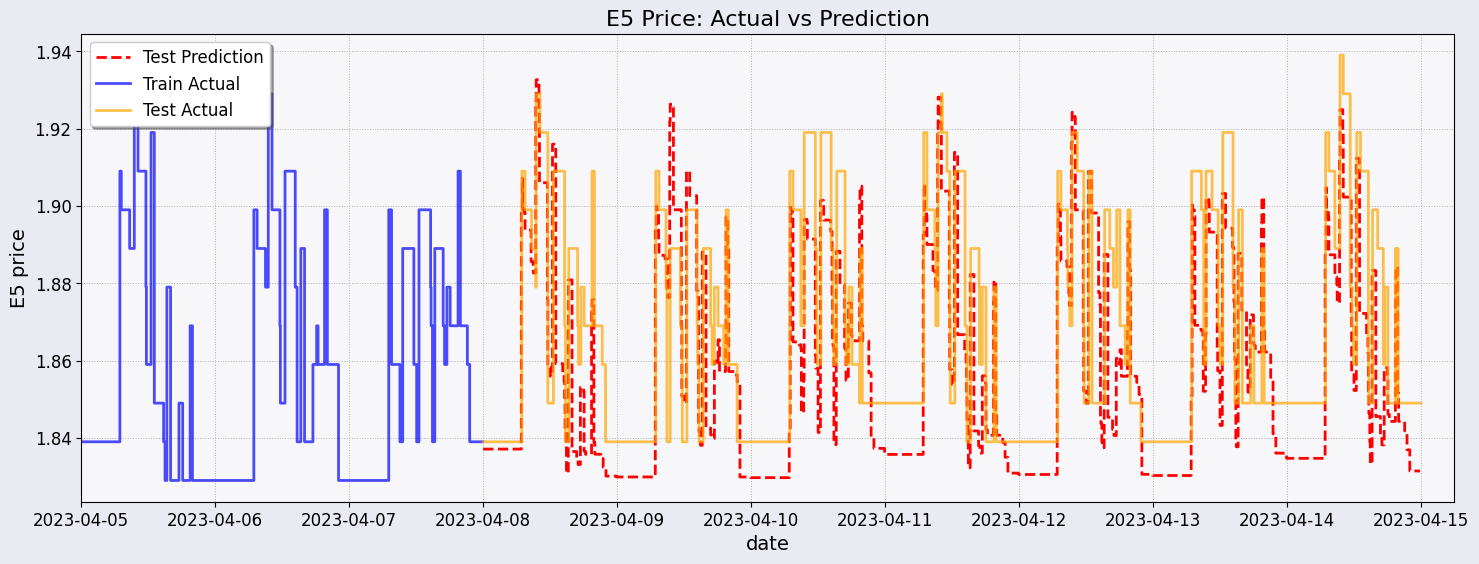

Successfully processed df23

Processing dataset: df24
[0.24650247 0.04738088 0.0167013  0.0239745  0.66544084]
[  -1  -24 -288 -576 -864]
1-Day MAE in cent: 2.5161
1-Day RMSE in cent: 3.1527
1-Day r2-score: 0.3858
3-Day MAE in cent: 2.0139
3-Day RMSE in cent: 2.5342
3-Day r2-score: 0.6727
7-Day MAE in cent: 3.5453
7-Day RMSE in cent: 4.4386
7-Day r2-score: 0.2456


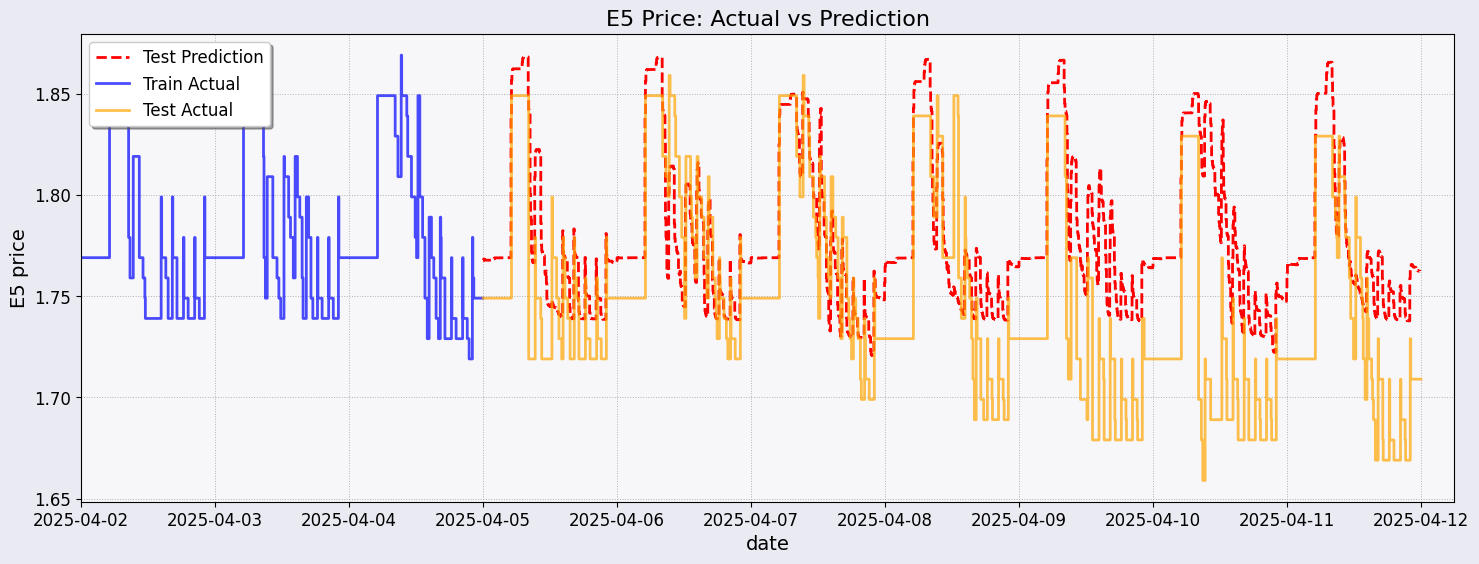

Successfully processed df24

Processing dataset: df25
[0.04684397 0.00515193 0.02044635 0.06133301 0.86622474]
[  -1  -84 -288 -576 -864]
1-Day MAE in cent: 1.2496
1-Day RMSE in cent: 1.7600
1-Day r2-score: 0.6040
3-Day MAE in cent: 1.6371
3-Day RMSE in cent: 2.0338
3-Day r2-score: 0.5549
7-Day MAE in cent: 1.7444
7-Day RMSE in cent: 2.1466
7-Day r2-score: 0.4861


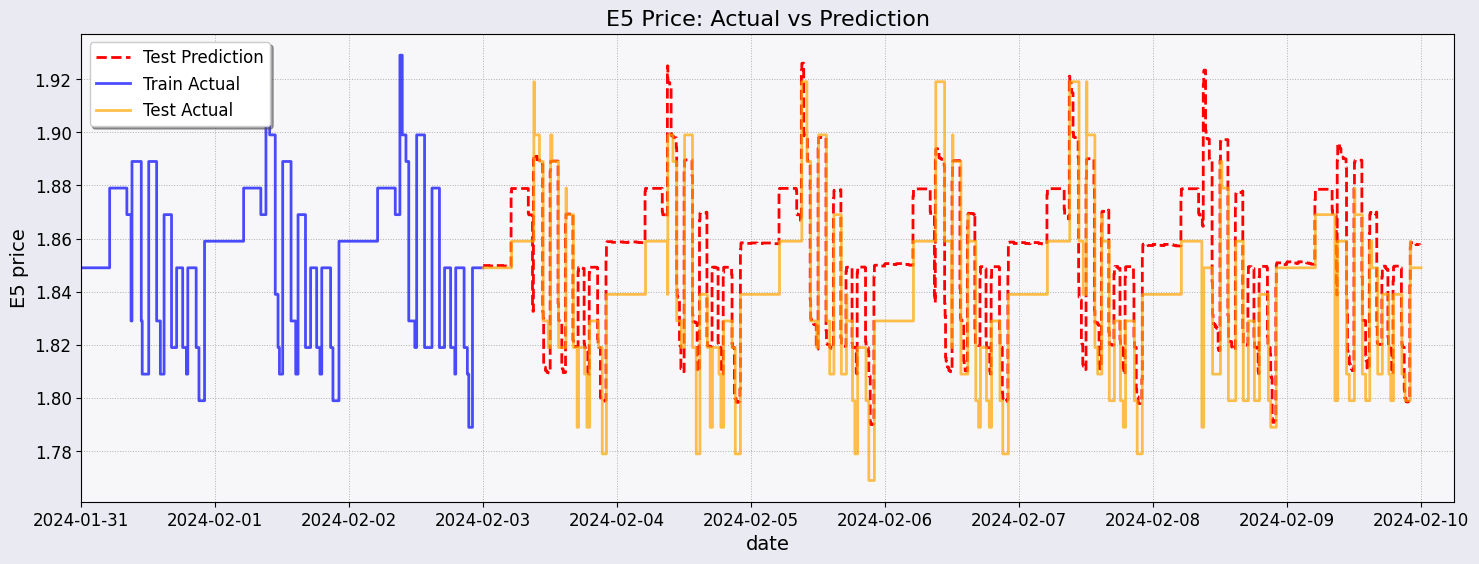

Successfully processed df25

Processing dataset: df26
[0.15752192 0.84247808]
[  -1 -288]
1-Day MAE in cent: 2.2149
1-Day RMSE in cent: 2.6801
1-Day r2-score: 0.6320
3-Day MAE in cent: 2.2009
3-Day RMSE in cent: 2.6535
3-Day r2-score: 0.6440
7-Day MAE in cent: 2.4962
7-Day RMSE in cent: 3.0204
7-Day r2-score: 0.5125


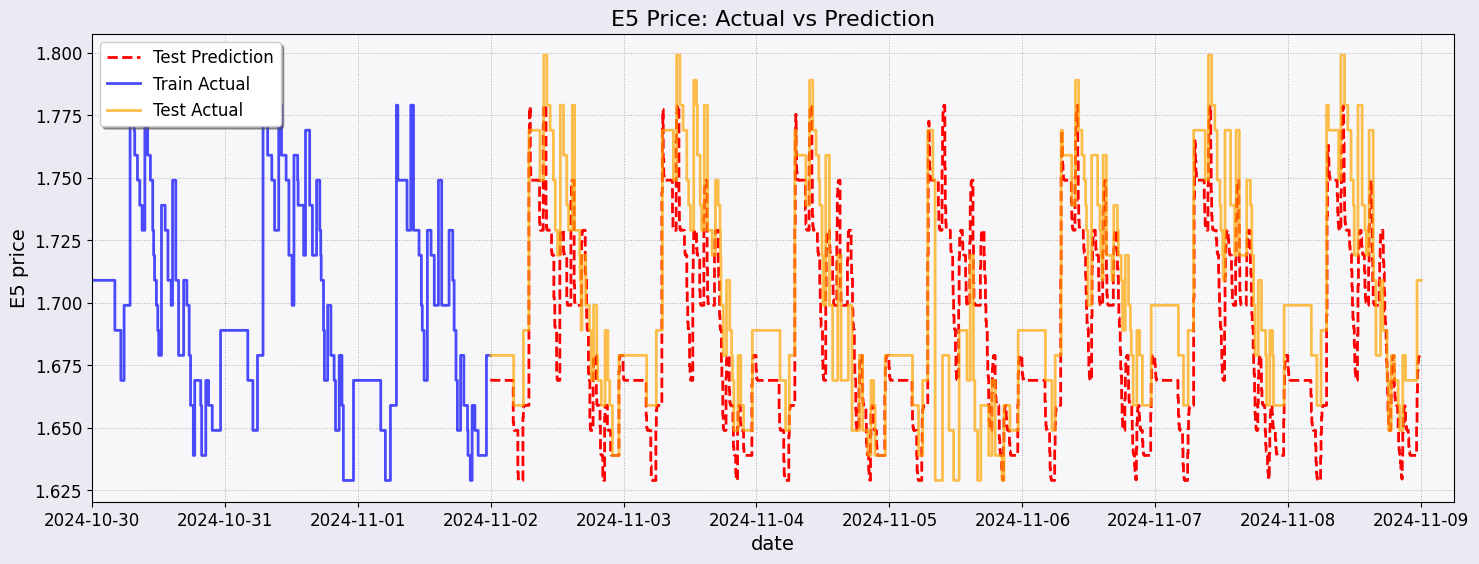

Successfully processed df26

Processing dataset: df27
[0.00590537 0.47859786 0.51549678]
[  -1 -288 -576]
1-Day MAE in cent: 1.9478
1-Day RMSE in cent: 2.3559
1-Day r2-score: 0.5403
3-Day MAE in cent: 2.2764
3-Day RMSE in cent: 2.7956
3-Day r2-score: 0.4647
7-Day MAE in cent: 2.9805
7-Day RMSE in cent: 3.5758
7-Day r2-score: 0.3735


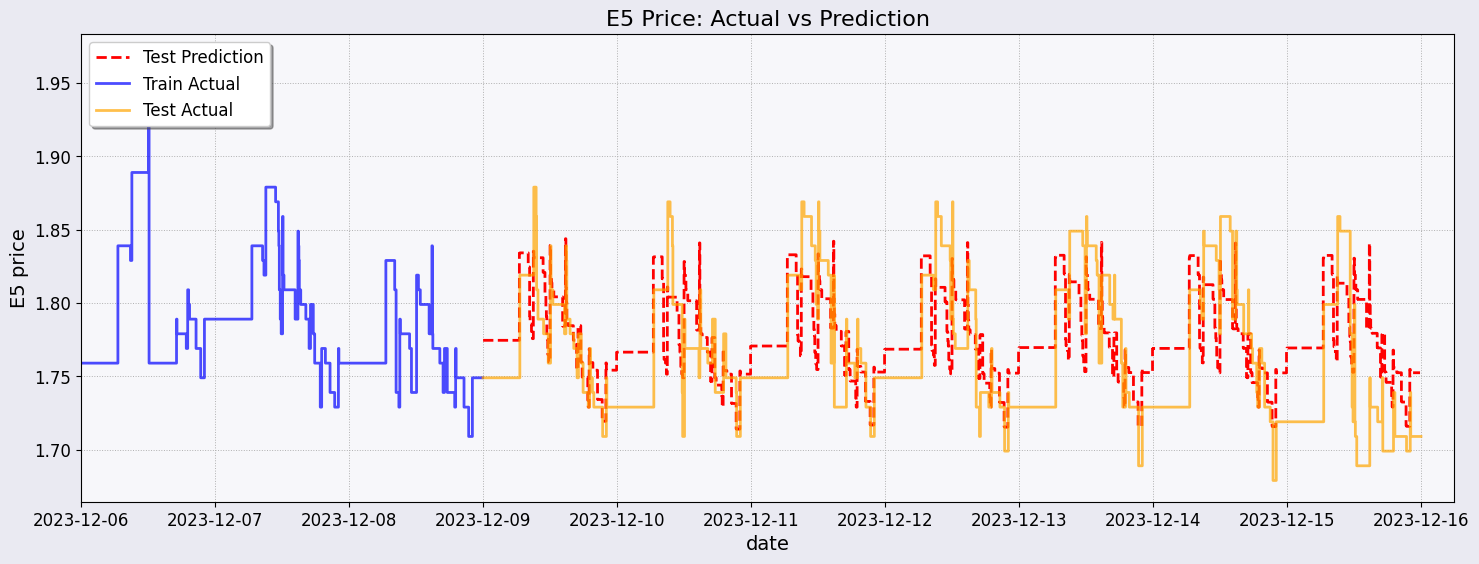

Successfully processed df27

Processing dataset: df28
[0.07731395 0.22620899 0.02728856 0.06853832 0.60065019]
[  -1  -93 -288 -576 -864]
1-Day MAE in cent: 1.2899
1-Day RMSE in cent: 1.7555
1-Day r2-score: 0.6963
3-Day MAE in cent: 1.7004
3-Day RMSE in cent: 2.3328
3-Day r2-score: 0.4612
7-Day MAE in cent: 2.5123
7-Day RMSE in cent: 3.2373
7-Day r2-score: 0.2577


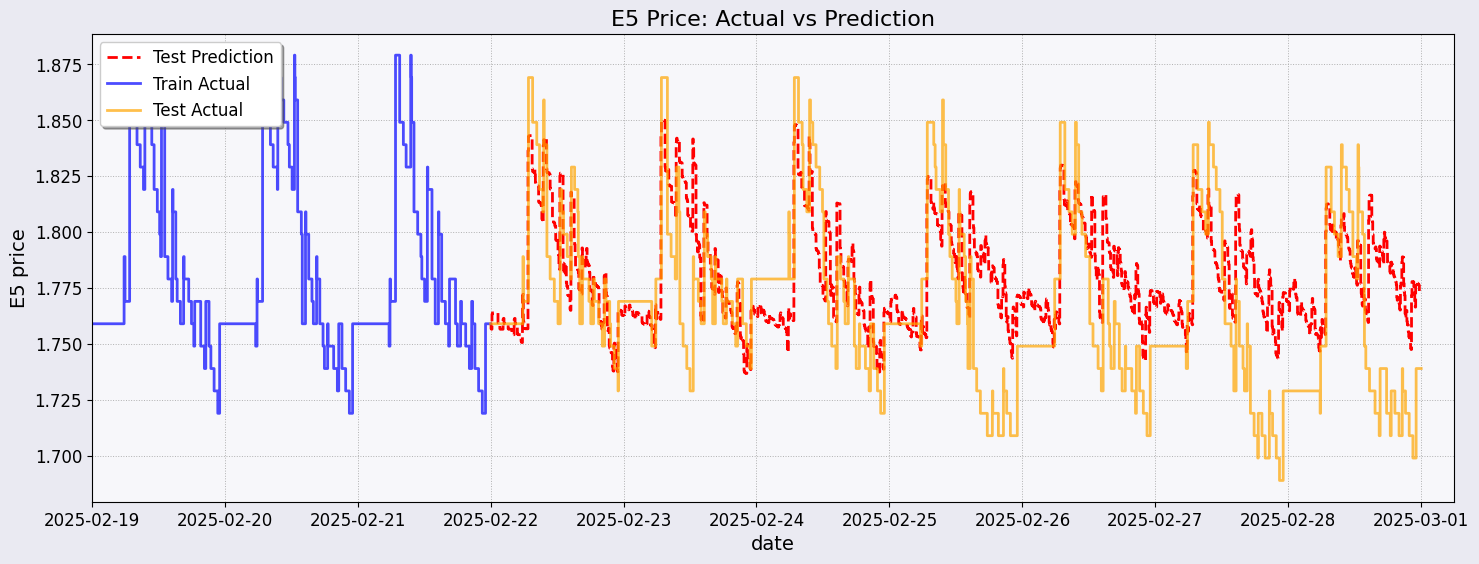

Successfully processed df28

Processing dataset: df29
[0.18742401 0.29350383 0.51907217]
[  -1 -288 -576]
1-Day MAE in cent: 0.0000
1-Day RMSE in cent: 0.0000
1-Day r2-score: 1.0000
3-Day MAE in cent: 0.0000
3-Day RMSE in cent: 0.0000
3-Day r2-score: 1.0000
7-Day MAE in cent: 0.0000
7-Day RMSE in cent: 0.0000
7-Day r2-score: 1.0000


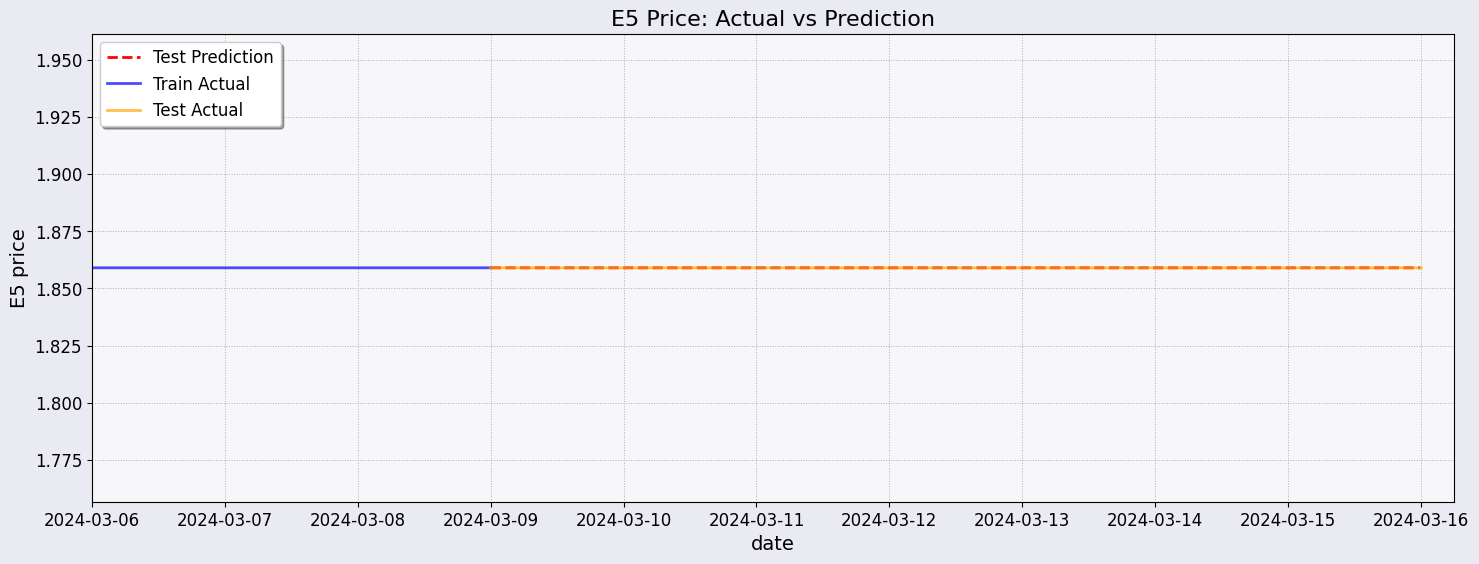

Successfully processed df29

Processing dataset: df30
[0.24283307 0.0971523  0.66001463]
[  -1 -288 -576]
1-Day MAE in cent: 0.9367
1-Day RMSE in cent: 1.4744
1-Day r2-score: 0.7145
3-Day MAE in cent: 1.2775
3-Day RMSE in cent: 1.8913
3-Day r2-score: 0.5852
7-Day MAE in cent: 2.5698
7-Day RMSE in cent: 3.4513
7-Day r2-score: 0.0142


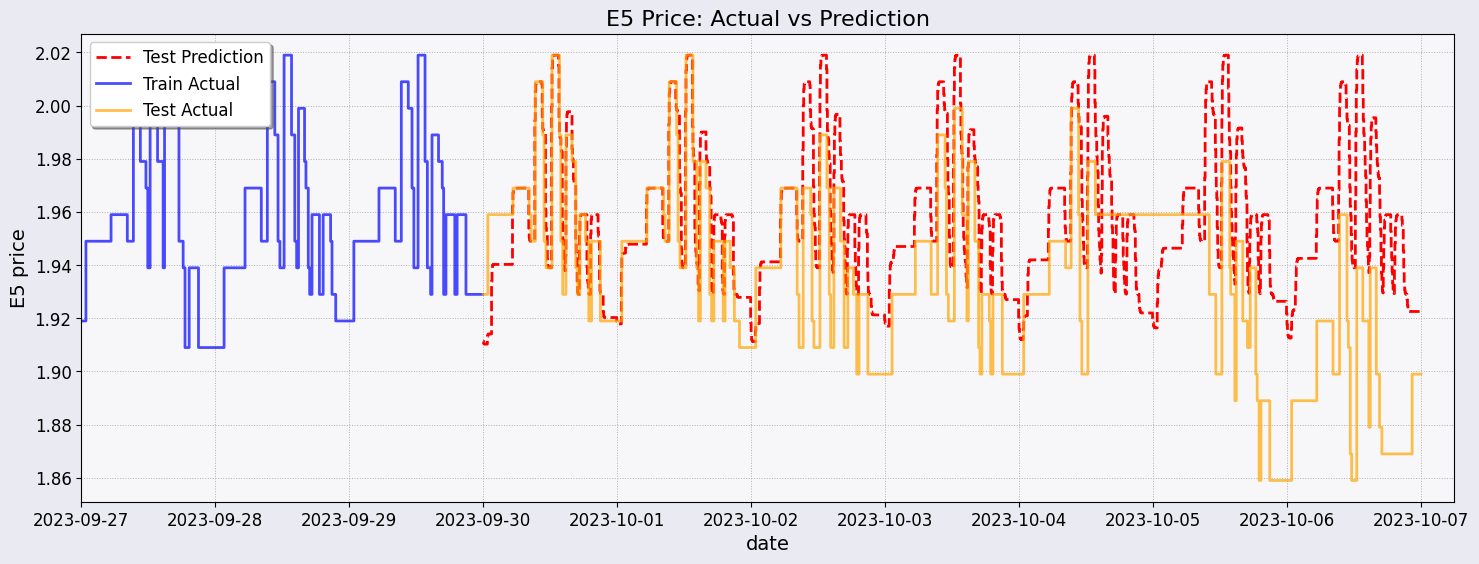

Successfully processed df30

=== Error Summary ===
All datasets processed successfully!


In [17]:
forecast_freq = 5 # minutes, discretization between individual values of the forecast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter


# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (train, test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_Nico_{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')

            df = pd.concat([train, test], ignore_index=True)

            features = [-1,-2,-3,-4,-5,-288,-(7*288)]
            b0 = np.array([0.15,0.08,0.06,0.04,0.02,0.55,0.1]) # Can be randomly chosen. Is useless if model.fit_pacf is used
    
            model = FuelProphet_abs(b0=b0,features=features) # model = FuelProphet(b0=b0,features=features)
            model.fit_pacf(train,threshold=0.2)
            model.normalize()
            pred = model.predict(X=train,num_predictions=(7*288)) # 7days *288 5-minute steps
            print(model.b)
            print(model.features)


            xmin = pred['datetime'].iloc[0] - pd.Timedelta(days=3)
            xmax = test['datetime'].max()

            train_start = pd.to_datetime(train['datetime'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(train['datetime'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)
            train_plot_start = pd.to_datetime(train['datetime'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(train['datetime'].iloc[-1]) + pd.Timedelta(days = 1)

            train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
            test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1.25))

            mae_1_day, mae_3_day, mae_7_day, rmse_1_day, rmse_3_day, rmse_7_day, r2_1_day, r2_3_day, r2_7_day = plot_forecast(
              df_train=train,
              df_test=test,
              station_uuid=None,
              df_train_prediction=None,
              df_test_prediction=pred,
              train_dates=train_dates_plot,
              test_dates=test_dates_plot,
              train_dates_plot=train_dates_plot,
              test_dates_plot=test_dates_plot
              )
            mlflow.log_artifact("prediction.png")
            mlflow.log_metrics({
            "mae_1_day": mae_1_day,
            "mae_3_day": mae_3_day,
            "mae_7_day": mae_7_day,
            "rmse_1_day": rmse_1_day,
            "rmse_3_day": rmse_3_day,
            "rmse_7_day": rmse_7_day,
            "r2_1_day": r2_1_day,
            "r2_3_day": r2_3_day,
            "r2_7_day": r2_7_day
            })
            print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)
        
        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

In [18]:
mlflow.end_run()


=== Error Summary ===
Total errors: 30

df06:
Error in df06: Found input variables with inconsistent numbers of samples: [554, 864]

In [19]:
#Check data:

%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
